In [5]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [1]:
from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [2]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [3]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        # nNN = [(0, 1, np.array([1])), (1, 0, np.array([1]))]
        # nnNN = [(0, 0, np.array([2])), (1, 1, np.array([2]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        # kwargs['pairs'].setdefault('nearest_neighbors', NNx+NNy+NNz)
        # kwargs['pairs'].setdefault('next_nearest_neighbors', nNN)
        # kwargs['pairs'].setdefault('next_next_nearest_neighbors', nnNN)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        # gs = GroupedSite([fs, fs, fs, fs])
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sigmax', u2, 'Sigmax', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sigmay', u2, 'Sigmay', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [7]:
def run():

    data = dict(ent_spectrum=[])

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=1., L=20, verbose=1, bc_MPS='infinite')

    dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'svd_min': 1.e-10,
        },
        'lanczos_params': {
            'N_min': 5,
            'N_max': 20
        },
        'chi_list': {
            0: 9,
            10: 49,
            20: 100
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 150,
        'verbose': 1.,
    }

    prod_state = ["up"] * (4 * model_params['L'])

    eng = None


    print("=" * 100)


    if eng is None:  # first time in the loop
        M = KitaevLadderModel(model_params)
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        del eng.engine_params['chi_list']
        M = KitaevLadderModel(model_params)
        eng.init_env(model=M)

    E, psi = eng.run()

    data['ent_spectrum'].append(psi.entanglement_spectrum(by_charge=True)[0])

    return data


def plot_results(data):

    plt.figure()
    ax = plt.gca()
    ax.plot(data['ent_spectrum'], marker='o')
    ax.set_xlabel(r"DMRG Step")
    ax.set_ylabel(r"$ E $")
    plt.savefig("KitaevLadderModel.pdf")


In [8]:
data = run()
# plot_results(data)
print(data)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=20 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:124: UserWarning: unused parameter ['bc_MPS'] for KitaevLadderModel

  warnings.warn(msg.format(keys=sorted(unused), descr=warn))


parameter 'verbose'=1.0 for Sweep
parameter 'lanczos_params'={'N_min': 5, 'N_max': 20} for Sweep
parameter 'trunc_params'={'svd_min': 1e-10} for Sweep
parameter 'chi_list'={0: 9, 10: 49, 20: 100} for Sweep
Setting chi_max = 9
parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Setting chi_max = 49
sweep 10, age = 80
Energy = -66.5295624002501711, S = nan, norm_err = 2.5e-03
Current memory usage 230.1 MB, time elapsed: 31.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5343e-04, max_E_trunc = 6.2699e-04
MPS bond dimensions: [2, 4, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 4, 2]
Setting chi_max = 100
sweep 2

[None, None, None, None]


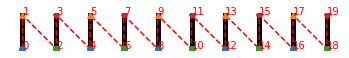

In [6]:
plot_lattice()